# Sudoku

Beim klassischen Sudoku ist das Ziel ein 9x9-Gitter so mit den Zahlen 1-9 zu füllen, dass in jeder Zeile, jeder Spalte und jedem 3x3 Unterquadrate jede Zahl nur einmal vorkommt. Die Lösung eines ganzen Rätsels ist lediglich durch ein paar vorgegebener Zahlen eindeutig bestimmt. Aufgabe ist es, basierend auf den bereits befüllten Kästchen die restlichen Einträge zu füllen.

Ein Beispiel wäre zum Beispiel das folgende Sudoku<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1):

<div>
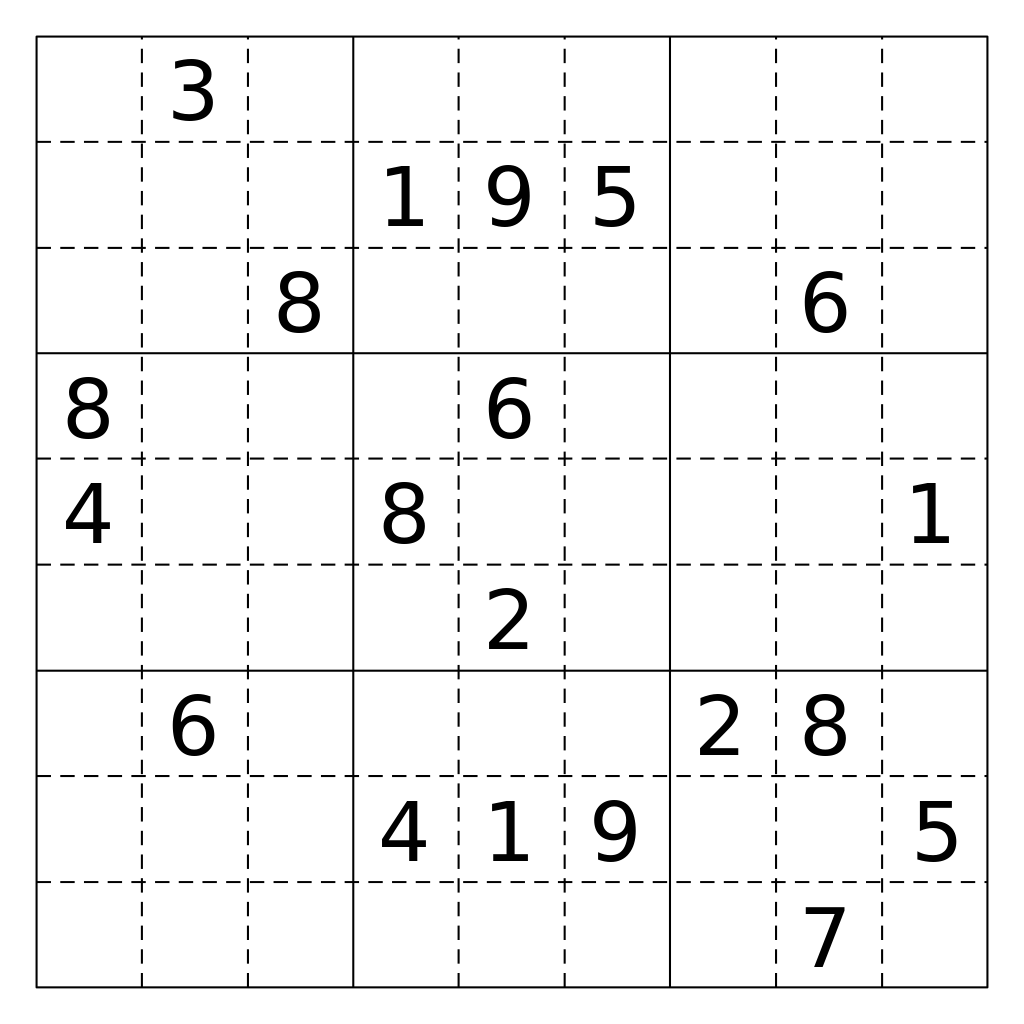
</div>


mit der eindeutigen Lösung<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2):

<div>
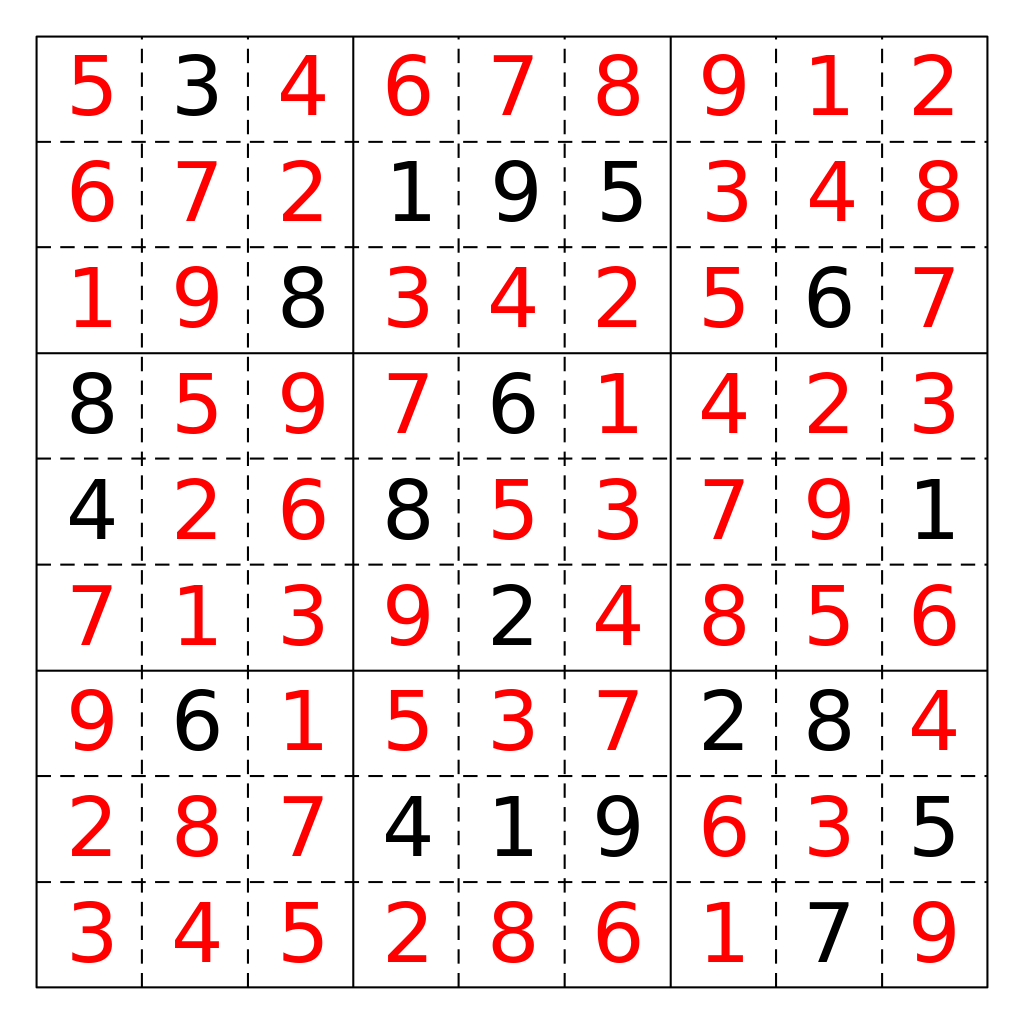
</div>

<a name="cite_note-1"></a>1. [https://de.wikipedia.org/wiki/Sudoku#/media/Datei:Sudoku_problem_1.svg](#cite_ref-1) 

<a name="cite_note-2"></a>2. [https://de.wikipedia.org/wiki/Sudoku#/media/Datei:Sudoku_solution_1.svg](#cite_ref-2)

# Lösen von Sudokus mittels SAT

Das allgemeine Problem ein $n^2\times n^2$-Gitter zu lösen ist NP-vollständig, also genau so schwer wie das Erfüllbarkeitsproblem (SAT). Im Folgenden werden wir eine allgemeine SAT-Formulierung für beliebige Sudokus erstellen.

## Der Z3 Solver

Z3 ist ein open source SMT Solver der auch eine SAT-Solving Engine beinhaltet. Z3 ermöglicht das Formulieren von Booleschen Constraints als beliebig verschachtelten Expression Tree. Eine Formel muss also nicht als CNF Formuliert werden. 


Um Z3 mit `pip` zu installieren einfach `pip install z3-solver` ausführen.


Hier ein kurzes Beispiel für die Verwendung von Z3 um Unerfüllbarkeit des folgenden Miters zu beweisen

![Equivalence Checking Miter](miter.png "Miter")

In [1]:
import z3
import numpy as np

In [2]:
# Declare Boolean variables
a = z3.Bool("a")
b = z3.Bool("b")
c = z3.Bool("c")

# Initialize solver
solver = z3.Solver()

# Create circuit constraints
and_1 = z3.And(a, c)
or_1 = z3.Or(and_1, b)

or_2 = z3.Or(a, b)
or_3 = z3.Or(b, c)
and_2 = z3.And(or_2, or_3)

miter = z3.Xor(or_1, and_2)

# Add constraints to solver

solver.add(miter)

# Solve
print(solver.check())

unsat


Für eine Satisfiable Formel können wir auch eine entsprechende Variablenbelegung auslesen. Nehmen wir als Beispiel den selben Miter aber dieses mal mit einem "Bug" im Schaltkreis:

![Equivalence Checking Miter with Bug](miter_bug.png "Bugged miter")

In [3]:
# Declare Boolean variables
a = z3.Bool("a")
b = z3.Bool("b")
c = z3.Bool("c")

# Initialize solver
solver = z3.Solver()

# Create circuit constraints
and_1 = z3.And(a, c)
or_1 = z3.Or(and_1, b)

or_2 = z3.And(a, b)
or_3 = z3.And(b, c)
and_2 = z3.Or(or_2, or_3)

miter = z3.Xor(or_1, and_2)

# Add constraints to solver

solver.add(miter)

# Solve
if solver.check() == z3.sat:
    print(solver.model())

[b = True, a = False, c = False]


Mit diesem kurzen Intro können wir uns nun wieder unserem ursprünglichen Problem zuwenden.

## Eingabeformat

Es wirkt natürlich eine Sudoku-Instanz als 2-dimensionales Gitter zu übergeben. Leere Einträge markieren wir mit ".". Das obige Sudoku codieren wir zum Beispiel wie folgt:

In [4]:
puzzle = np.array( [
    [".", "3", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", "1", "9", "5", ".", ".", "."],
    [".", ".", "8", ".", ".", ".", ".", "6", "."],
    ["8", ".", ".", ".", "6", ".", ".", ".", "."],
    ["4", ".", ".", "8", ".", ".", ".", ".", "1"],
    [".", ".", ".", ".", "2", ".", ".", ".", "."],
    [".", "6", ".", ".", ".", ".", "2", "8", "."],
    [".", ".", ".", "4", "1", "9", ".", ".", "5"],
    [".", ".", ".", ".", ".", ".", ".", "7", "."]
]
)
print(puzzle)

[['.' '3' '.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '1' '9' '5' '.' '.' '.']
 ['.' '.' '8' '.' '.' '.' '.' '6' '.']
 ['8' '.' '.' '.' '6' '.' '.' '.' '.']
 ['4' '.' '.' '8' '.' '.' '.' '.' '1']
 ['.' '.' '.' '.' '2' '.' '.' '.' '.']
 ['.' '6' '.' '.' '.' '.' '2' '8' '.']
 ['.' '.' '.' '4' '1' '9' '.' '.' '5']
 ['.' '.' '.' '.' '.' '.' '.' '7' '.']]


## Variablen

Zuerst müssen wir uns überlegen wie wir das Problem mit Booleschen Variablen kodieren. Eine Variable $k_{i,j}$ mit Semantik "Zahl $k$ ist in Reihe $i$ und Spalte $j$" wäre am Besten geeignet. Allerdings ist $k$ ein Integer und kein Bool. Eine Lösung ist es eine Boolesche Variable für jede Zahl, Reihe und Spalte zu haben:

$$\forall 0 \leq k < n: \forall 0 \leq i < n: \forall 0 \leq j < n:x_{i,j,k}$$

$x_{k,i,j}$ bedeutet "in Reihe $i$, Spalte $j$ steht die Zahl $k$". In Z3 können wir die Variablen so definieren:

In [5]:
def create_variables(n):
    """Create Boolean variables for the SAT instance.
    
    Args: 
        n (int): size of the Sudoku instance.
    
    Returns:
        variables: 3-dimensional list of Boolean z3 variables.
    """
    variables = []
    
    for i in range(n): # For every row 0 <= i < n
        column_variables = []
        for j in range(n): # For every column 0 <= j < n
            entry_variables = []
            for k in range(n): # For every number 0 <= k < n
                var = z3.Bool("x_%d_%d_%d"%(i,j,k+1))
                entry_variables.append(var) # Add variable x_i_j_k
            column_variables.append(entry_variables)
        variables.append(column_variables)
    return variables

In [7]:
variables = create_variables(9)
print("Number of Variables: %d"%(9*9*9))

print(variables)

Number of Variables: 729
[[[x_0_0_1, x_0_0_2, x_0_0_3, x_0_0_4, x_0_0_5, x_0_0_6, x_0_0_7, x_0_0_8, x_0_0_9], [x_0_1_1, x_0_1_2, x_0_1_3, x_0_1_4, x_0_1_5, x_0_1_6, x_0_1_7, x_0_1_8, x_0_1_9], [x_0_2_1, x_0_2_2, x_0_2_3, x_0_2_4, x_0_2_5, x_0_2_6, x_0_2_7, x_0_2_8, x_0_2_9], [x_0_3_1, x_0_3_2, x_0_3_3, x_0_3_4, x_0_3_5, x_0_3_6, x_0_3_7, x_0_3_8, x_0_3_9], [x_0_4_1, x_0_4_2, x_0_4_3, x_0_4_4, x_0_4_5, x_0_4_6, x_0_4_7, x_0_4_8, x_0_4_9], [x_0_5_1, x_0_5_2, x_0_5_3, x_0_5_4, x_0_5_5, x_0_5_6, x_0_5_7, x_0_5_8, x_0_5_9], [x_0_6_1, x_0_6_2, x_0_6_3, x_0_6_4, x_0_6_5, x_0_6_6, x_0_6_7, x_0_6_8, x_0_6_9], [x_0_7_1, x_0_7_2, x_0_7_3, x_0_7_4, x_0_7_5, x_0_7_6, x_0_7_7, x_0_7_8, x_0_7_9], [x_0_8_1, x_0_8_2, x_0_8_3, x_0_8_4, x_0_8_5, x_0_8_6, x_0_8_7, x_0_8_8, x_0_8_9]], [[x_1_0_1, x_1_0_2, x_1_0_3, x_1_0_4, x_1_0_5, x_1_0_6, x_1_0_7, x_1_0_8, x_1_0_9], [x_1_1_1, x_1_1_2, x_1_1_3, x_1_1_4, x_1_1_5, x_1_1_6, x_1_1_7, x_1_1_8, x_1_1_9], [x_1_2_1, x_1_2_2, x_1_2_3, x_1_2_4, x_1_2_5, x_1_2_6, x_1

## Encoding der Sudoku Regeln

Unabhängig von der spezifischen Sudoku-Instanz müssen wir in jedem Fall die Regeln von Sudoku in die SAT-Instanz encoden. Die Regeln von Sudoku sind symmetrisch bezüglich Reihen, Spalten und Unterquadraten. Für alle Fälle darf jede Zahl nur einmal vorkommen. Wir können also eine allgemeine Methode $\mathit{ExactlyOne}$ definieren die für eine Liste an Variable ein Constraint erstellt, dass genau dann wahr ist wenn genau eine Variable der Liste auf $1$ gesetzt ist. 

Wenn genau eine Variable einer Menge an Variable $1$ sein soll, müssen alle anderen Variablen $0$ sein. Dies gilt für alle Variablen. Bei einem kleinen Beispiel sieht dies so aus:

$$\mathit{ExactlyOne}(a, b, c) = (a \land \neg b \land \neg c) \lor (\neg a \land b \land \neg c) \lor (\neg a \land \neg b \land c)$$

Wir können dies einfach verallgemeinern:

In [8]:
def exactly_one(variables):
    """Create Exactly-One Constraint
    
    Args:
        variables: list of z3 Boolean variables.
        
    Returns:
        z3 expression encoding the constraint that only one of the Booleans in variables is set to 1
    """
    cubes = []
    
    for var in variables:
        cube = []
        cube.append(var)
        for other in variables:
            if other == var:
                continue 
                
            cube.append(z3.Not(other)) # add !other
        cubes.append(z3.And(cube)) # add the AND of all variables in the cube
    
    return z3.Or(cubes) # Finally OR together all individual cubes

In [9]:
print(exactly_one(variables[0][0])) # exactly one number in first cell

Or(And(x_0_0_1,
       Not(x_0_0_2),
       Not(x_0_0_3),
       Not(x_0_0_4),
       Not(x_0_0_5),
       Not(x_0_0_6),
       Not(x_0_0_7),
       Not(x_0_0_8),
       Not(x_0_0_9)),
   And(x_0_0_2,
       Not(x_0_0_1),
       Not(x_0_0_3),
       Not(x_0_0_4),
       Not(x_0_0_5),
       Not(x_0_0_6),
       Not(x_0_0_7),
       Not(x_0_0_8),
       Not(x_0_0_9)),
   And(x_0_0_3,
       Not(x_0_0_1),
       Not(x_0_0_2),
       Not(x_0_0_4),
       Not(x_0_0_5),
       Not(x_0_0_6),
       Not(x_0_0_7),
       Not(x_0_0_8),
       Not(x_0_0_9)),
   And(x_0_0_4,
       Not(x_0_0_1),
       Not(x_0_0_2),
       Not(x_0_0_3),
       Not(x_0_0_5),
       Not(x_0_0_6),
       Not(x_0_0_7),
       Not(x_0_0_8),
       Not(x_0_0_9)),
   And(x_0_0_5,
       Not(x_0_0_1),
       Not(x_0_0_2),
       Not(x_0_0_3),
       Not(x_0_0_4),
       Not(x_0_0_6),
       Not(x_0_0_7),
       Not(x_0_0_8),
       Not(x_0_0_9)),
   And(x_0_0_6,
       Not(x_0_0_1),
       Not(x_0_0_2),
       Not(x_0_0_

Jetzt müssen wir dieses Constraint nur noch für jede Reihe, Zelle und Unterquadrat aufrufen:

In [10]:
def sudoku_constraints(variables):
    n = len(variables)
    
    constraints = []
    
    for number in range(n):
        # every number is only allowed once in every row
        for row in range(n):
            row_variables = []
            for column in range(n):
                row_variables.append(variables[row][column][number])
                
            constraints.append(exactly_one(row_variables))
                    

        # every number is only allowed once in every column
        for column in range(n):
            column_variables = []
            for row in range(n):
                column_variables.append(variables[row][column][number])
                
            constraints.append(exactly_one(column_variables))
        
        # every number is only allowed once in every subblock
        block_size = int(np.sqrt(n))
        for block_row in range(block_size):
            for block_column in range(block_size):
                block_variables = []
                for row in range(block_row*block_size, (block_row+1)*block_size):
                    for column in range(block_column*block_size, (block_column+1)*block_size):
                        block_variables.append(variables[row][column][number])
                
                constraints.append(exactly_one(block_variables))
        
    return z3.And(constraints) # All constraints need to be satisfied

Haben wir nun alle Regeln kodiert?

Nein! Unsere momentane Formulierung erlaubt Lösungen bei der das Gitter nicht vollständig befüllt ist. Wir müssen noch codieren, dass in jeder Zelle irgendein Eintrag stehen soll:

In [11]:
def grid_fill_constraints(variables):
    n = len(variables)
    constraints = []
    
    for row in range(n):
        for column in range(n):
            numbers = []
            for number in range(n):
                numbers.append(variables[row][column][number])
            constraints.append(z3.Or(numbers)) # At least one number has to be in the grid cell
    return z3.And(constraints)

## Encoding der initialen Belegung

Nachdem wir die grundlegenden Regeln von Sudoku kodiert haben, müssen wir uns nur noch überlegeben wie wir eine bestimmte Instanz lösen. Dies ist mit unserer Formulierung tatsächlich sehr einfach. Wenn in Reihe $i$, Spalte $j$ die Zahl $k$ vorkommt, fügen wir einfach das constraint $x_{i,j,k}=1$ zum Solver hinzu. 

In [12]:
def puzzle_constraints(puzzle, variables):
    units = []
    n = len(variables)
    for row in range(n):
        for column in range(n):
            if puzzle[row][column] != ".":
                number = int(puzzle[row][column])
                units.append(variables[row][column][number-1])
    return z3.And(units)

## Umwandlung einer Belegung in ein Sudoku-Gitter

Wenn der z3-Solver eine gültige Belegung gefunden hat, müssen wir daraus noch die Lösung des Rätsels auslösen. Ohne in die Details zu gehen, definieren wir hierfür eine Funktion:

In [13]:
def convert_model_to_solution(variables, model):
    n = len(variables)
    grid = np.zeros((n,n))
    for row in range(n):
        for column in range(n):
            for number in range(n):
                var_eval = model.evaluate(variables[row][column][number])
                try:
                    if var_eval:
                        grid[row, column] = number+1
                except: 
                    pass
    return grid.astype(int)

In [14]:
def solve_sudoku(puzzle):
    solver = z3.Solver()
    
    variables = create_variables(len(puzzle))
    
    print("Creating Sudoku Instance")
    solver.add(sudoku_constraints(variables))
    solver.add(puzzle_constraints(puzzle, variables))
    solver.add(grid_fill_constraints(variables))
    
    print("Solving Instance")
    
    if solver.check() == z3.sat:
        print("Solution:")
        model = solver.model()
        return convert_model_to_solution(variables, model)
    
    return "Sudoku instance is unsolvable"

Mit dieser Methode können wir nun versuchen unser Sudoku von oben zu lösen:

In [16]:
print(solve_sudoku(puzzle))

Creating Sudoku Instance
Solving Instance
Solution:
[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]


Wie sieht es mit einem unlösbaren Sudoku aus?

In [17]:
unsolvable = np.array( [
    [".", ".", ".", "1", ".", ".", ".", ".", "."],
    [".", ".", ".", "2", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    ["1", "2", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", "1", "2", "."],
    [".", ".", ".", ".", ".", "1", ".", ".", "."],
    [".", ".", ".", ".", ".", "2", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."]
]
)

solve_sudoku(unsolvable)

Creating Sudoku Instance
Solving Instance


'Sudoku instance is unsolvable'

Wenn wir keine initiale Belegung vorgeben (oder generell wenn es mehrere valide Lösungen gibt), findet der Solver irgendeine mögliche Konfiguration:

In [18]:
empty = np.array( [
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", ".", ".", ".", ".", ".", ".", "."]
]
)

solve_sudoku(empty)

Creating Sudoku Instance
Solving Instance
Solution:


array([[5, 6, 2, 3, 4, 1, 9, 7, 8],
       [1, 7, 9, 8, 5, 6, 3, 4, 2],
       [8, 4, 3, 9, 2, 7, 5, 1, 6],
       [7, 9, 5, 2, 1, 4, 6, 8, 3],
       [2, 8, 6, 5, 7, 3, 4, 9, 1],
       [3, 1, 4, 6, 8, 9, 7, 2, 5],
       [4, 3, 8, 7, 6, 2, 1, 5, 9],
       [6, 5, 7, 1, 9, 8, 2, 3, 4],
       [9, 2, 1, 4, 3, 5, 8, 6, 7]])

In [19]:
solve_sudoku(empty)

Creating Sudoku Instance
Solving Instance
Solution:


array([[5, 6, 2, 3, 4, 1, 9, 7, 8],
       [1, 7, 9, 8, 5, 6, 3, 4, 2],
       [8, 4, 3, 9, 2, 7, 5, 1, 6],
       [7, 9, 5, 2, 1, 4, 6, 8, 3],
       [2, 8, 6, 5, 7, 3, 4, 9, 1],
       [3, 1, 4, 6, 8, 9, 7, 2, 5],
       [4, 3, 8, 7, 6, 2, 1, 5, 9],
       [6, 5, 7, 1, 9, 8, 2, 3, 4],
       [9, 2, 1, 4, 3, 5, 8, 6, 7]])